In [44]:
pip install torchinfo lightning

Note: you may need to restart the kernel to use updated packages.


In [45]:
import torch
from torchvision.transforms import ToTensor, Compose, Resize, Lambda, RandomHorizontalFlip, RandomRotation, RandomVerticalFlip,RandomRotation, RandomAffine, ColorJitter, RandomErasing
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, random_split
import numpy as np
from matplotlib.pyplot import subplots
from torch import nn
from torchinfo import summary
import torch.nn.functional as F
import lightning as L
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint

In [46]:
import os
import pandas as pd

# Caminho base
base_dir = "data/imgmask"

# DataFrame com as colunas desejadas
ImgMask_Data = pd.DataFrame(columns=["class", "filepath"])

# Percorrer todas as subpastas e arquivos
for root, dirs, files in os.walk(base_dir):
    # Pega o nome da subpasta como classe (nível imediatamente abaixo de imgmask)
    class_name = os.path.basename(root)
    
    # Ignora a pasta base "imgmask" em si
    if class_name == "imgmask":
        continue

    for file in files:
        if file.endswith(".png"):
            file_path = os.path.join(root, file)
            ImgMask_Data = pd.concat([
                ImgMask_Data,
                pd.DataFrame({
                    "class": [class_name],
                    "filepath": [file_path]
                })
            ], ignore_index=True)

print("✅ Dataset criado com sucesso!")
print("Total de imagens .png:", len(ImgMask_Data))
print(ImgMask_Data.head())


✅ Dataset criado com sucesso!
Total de imagens .png: 4049
             class                                      filepath
0  im_Koilocytotic  data/imgmask/im_Koilocytotic/imgmask_628.png
1  im_Koilocytotic  data/imgmask/im_Koilocytotic/imgmask_685.png
2  im_Koilocytotic  data/imgmask/im_Koilocytotic/imgmask_367.png
3  im_Koilocytotic  data/imgmask/im_Koilocytotic/imgmask_410.png
4  im_Koilocytotic  data/imgmask/im_Koilocytotic/imgmask_490.png


In [47]:
from PIL import Image
from torch.utils.data import Dataset

class CellsDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        # Mapeia cada classe para um índice numérico
        self.class_to_idx = {cls: i for i, cls in enumerate(self.data["class"].unique())}
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = self.data.loc[idx, "filepath"]
        label = self.class_to_idx[self.data.loc[idx, "class"]]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, label



In [48]:
transform = Compose([
    Resize((128, 128)),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    RandomRotation(10),
    ToTensor(),
])

In [49]:
full_dataset = CellsDataset(ImgMask_Data, transform=transform)

# tamanhos do split
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42)  # para reprodutibilidade
)


In [50]:
val_size = int(0.2 * train_size)
train_size_final = train_size - val_size

train_dataset, val_dataset = random_split(
    train_dataset,
    [train_size_final, val_size],
    generator=torch.Generator().manual_seed(42)
)


In [51]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


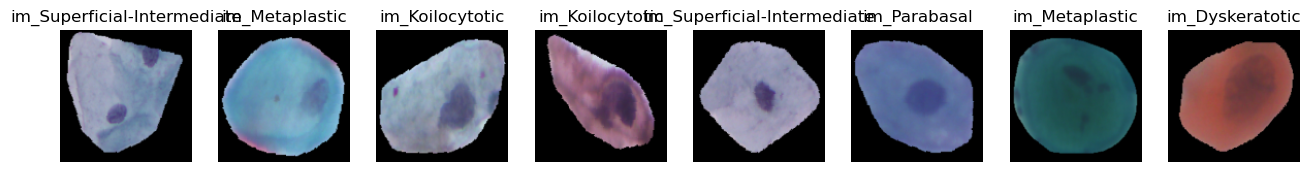

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# pegar um batch do dataloader
images, labels = next(iter(train_loader))

# converter tensor para numpy (para visualização)
images = images.numpy().transpose((0, 2, 3, 1))  # [B, H, W, C]
labels = labels.numpy()

# função auxiliar para mostrar imagens
def show_images(imgs, labels, class_names, n=8):
    plt.figure(figsize=(16, 4))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        img = imgs[i]
        plt.imshow(img)
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()

# Recupera os nomes das classes do dataset original
class_names = list(full_dataset.class_to_idx.keys())

# mostra 8 imagens aleatórias
show_images(images, labels, class_names, n=8)


In [53]:
class BuildingBlock(nn.Module):
    def __init__(self ,
                    in_channels ,
                    out_channels):
        super(BuildingBlock , self).__init__ ()
        self.conv = nn.Conv2d(in_channels=in_channels ,
                                out_channels=out_channels ,
                                kernel_size =(3 ,3),
                                padding='same')
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU ()
        self.pool = nn.MaxPool2d(kernel_size =(2 ,2))
    def forward(self , x):
      return self.pool(self.activation(self.bn(self.conv(x))))

In [54]:
sizes = []

for path in ImgMask_Data["filepath"].sample(200):  # pega 200 amostras pra não demorar
    with Image.open(path) as img:
        sizes.append(img.size)  # (w, h)

sizes_df = pd.DataFrame(sizes, columns=["width", "height"])
print(sizes_df.describe())


           width      height
count  200.00000  200.000000
mean   216.65000  192.295000
std    106.04402   94.272341
min     65.00000   49.000000
25%    132.00000  118.000000
50%    189.50000  163.500000
75%    282.50000  249.000000
max    482.00000  470.000000


In [55]:
import os
import pandas as pd

Cells_Data = pd.DataFrame(columns=["class", "filepath"])

for root, dirs, files in os.walk("archive"):
    if os.path.basename(root) == "CROPPED":
        class_name = os.path.basename(os.path.dirname(root))
        
        for file in files:
            if file.endswith(".bmp"):
                file_path = os.path.join(root, file)
                Cells_Data = pd.concat([Cells_Data, pd.DataFrame({
                    "class": [class_name],
                    "filepath": [file_path]
                })], ignore_index=True)

"Total de imagens .bmp:", len(Cells_Data)

('Total de imagens .bmp:', 4049)

In [56]:
from PIL import Image
from torch.utils.data import Dataset

class CellsDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        # Mapeia cada classe para um índice numérico
        self.class_to_idx = {cls: i for i, cls in enumerate(self.data["class"].unique())}
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = self.data.loc[idx, "filepath"]
        label = self.class_to_idx[self.data.loc[idx, "class"]]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, label



In [57]:
import torch
from torchvision.transforms import ToTensor, Compose, Resize, Lambda, RandomHorizontalFlip, RandomRotation
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, random_split
import numpy as np
from matplotlib.pyplot import subplots
from torch import nn
from torchinfo import summary
import torch.nn.functional as F
import lightning as L
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint




In [58]:
from torchvision.transforms import Compose, Resize, ToTensor, RandomHorizontalFlip, RandomRotation

transform = Compose([
    Resize((128, 128)),
    RandomHorizontalFlip(),
    RandomRotation(10),
    ToTensor()
])


In [59]:
full_dataset = CellsDataset(Cells_Data, transform=transform)

# tamanhos do split
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42)  # para reprodutibilidade
)


In [60]:
val_size = int(0.2 * train_size)
train_size_final = train_size - val_size

train_dataset, val_dataset = random_split(
    train_dataset,
    [train_size_final, val_size],
    generator=torch.Generator().manual_seed(42)
)


In [61]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


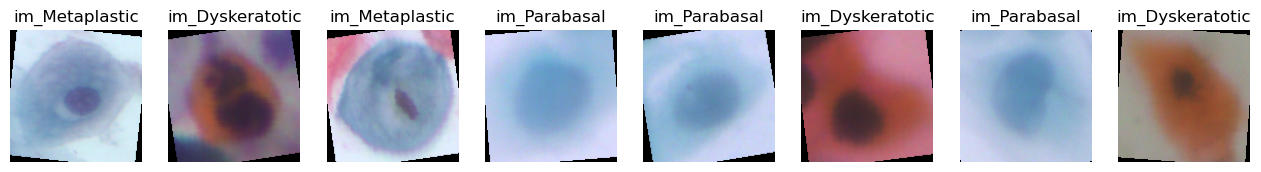

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# pegar um batch do dataloader
images, labels = next(iter(train_loader))

# converter tensor para numpy (para visualização)
images = images.numpy().transpose((0, 2, 3, 1))  # [B, H, W, C]
labels = labels.numpy()

# função auxiliar para mostrar imagens
def show_images(imgs, labels, class_names, n=8):
    plt.figure(figsize=(16, 4))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        img = imgs[i]
        plt.imshow(img)
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()

# Recupera os nomes das classes do dataset original
class_names = list(full_dataset.class_to_idx.keys())

# mostra 8 imagens aleatórias
show_images(images, labels, class_names, n=8)


In [63]:
class double_conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(double_conv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=7, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


In [64]:
import torch
import torch.nn as nn

# Bloco com conexão residual
class ResidualDoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
        )
        # Projeção caso os canais mudem
        self.residual = (
            nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=False)
            if in_ch != out_ch else nn.Identity()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = self.residual(x)
        out = self.conv(x)
        out += identity
        return self.relu(out)

# Encoder + Classificador
class UNetEncoderClassifier(nn.Module):
    def __init__(self, in_ch=3, feat=[32, 64, 128, 256, 512], num_classes=5):
        super().__init__()

        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(2, 2)

        in_channels = in_ch
        for f in feat:
            self.downs.append(ResidualDoubleConv(in_channels, f))
            in_channels = f

        # Cabeça de classificação
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(in_channels, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),

            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        for down in self.downs:
            x = down(x)
            x = self.pool(x)

        x = self.gap(x).flatten(1)
        x = self.classifier(x)
        return x


In [65]:
def teste_tamanho():
    x = torch.randn(1, 1, 128, 128)
    model = UNetEncoderClassifier(in_ch=1)
    preds = model(x)
    print(preds.shape)
    print(x.shape)
teste_tamanho()


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])

In [ ]:
class LitUNetEncoderClassifier(L.LightningModule):
    def __init__(self, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.model   = UNetEncoderClassifier()
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def _step(self, batch, stage):
        x, y = batch
        y = y.long()       
        logits = self(x)                  
        loss   = self.loss_fn(logits, y)

        
        preds = torch.argmax(logits, dim=1)
        acc   = (preds == y).float().mean()

        self.log(f"{stage}_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log(f"{stage}_acc",  acc,  prog_bar=True, on_step=False, on_epoch=True)

        return loss

    def training_step(self, batch, batch_idx):
        return self._step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self._step(batch, "val")

    def test_step(self, batch, batch_idx):
        self._step(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="max", patience=3, factor=0.5
        )
        return {"optimizer": optimizer,
                "lr_scheduler": {"scheduler": scheduler, "monitor": "val_acc", "interval": "epoch", "frequency":1}}


In [ ]:
model_unet_ida = LitUNetEncoderClassifier()

checkpoint_callback_unet_ida = ModelCheckpoint(
    monitor="val_acc",
    mode = "max",
    save_top_k = 1,
    filename="best-unet-ida-classifier")

trainer = Trainer(
    accelerator = "auto",
    devices=1,
    max_epochs=100,
    precision=16,
    log_every_n_steps=10,
    callbacks=[checkpoint_callback_unet_ida]
)

trainer.fit(model_unet_ida, train_dataloaders=train_loader, val_dataloaders=val_loader)


/home/al.igor.alves/anaconda3/envs/ambiente_aluno/lib/python3.9/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/al.igor.alves/anaconda3/envs/ambiente_aluno/lib/python3.9/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type                  | Params | Mode 
----------------------------------------------------------
0 | model   | UNetEncoderClassifier | 5.3 M  | train
1 | loss_fn | CrossEntropyLoss      | 0      | train
----------------------------------------------------------
5.3 M 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/al.igor.alves/anaconda3/envs/ambiente_aluno/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/al.igor.alves/anaconda3/envs/ambiente_aluno/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
model_unet_ida = LitUNetEncoderClassifier.load_from_checkpoint(checkpoint_callback_unet_ida.best_model_path)
trainer.test(model_unet_ida, dataloaders=test_loader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/al.igor.alves/anaconda3/envs/ambiente_aluno/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9469135999679565
        test_loss            0.136699840426445
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.136699840426445, 'test_acc': 0.9469135999679565}]

In [72]:
mapa = {
    'im_Superficial-Intermediate': 'Normal',
    'im_Parabasal': 'Normal',
    'im_Metaplastic': 'Maligna',
    'im_Koilocytotic': 'Benigna',
    'im_Dyskeratotic': 'Benigna'
}

ImgMask_Data['categoria'] = ImgMask_Data['class'].map(mapa)

In [73]:
class CellsDatasetGeral(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        # Mapeia cada classe para um índice numérico
        self.ctg_to_idx = {ctg: i for i, ctg in enumerate(self.data["categoria"].unique())}
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = self.data.loc[idx, "filepath"]
        label = self.ctg_to_idx[self.data.loc[idx, "categoria"]]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [74]:
geral_dataset = CellsDatasetGeral(ImgMask_Data, transform=transform)

# tamanhos do split
train_size_geral = int(0.8 * len(geral_dataset))
test_size_geral = len(geral_dataset) - train_size_geral

train_dataset_geral, test_dataset_geral = random_split(
    geral_dataset,
    [train_size_geral, test_size_geral],
    generator=torch.Generator().manual_seed(42)  # para reprodutibilidade
)


In [75]:
val_size_geral = int(0.2 * train_size_geral)
train_size_final_geral = train_size_geral - val_size_geral

train_dataset_geral, val_dataset_geral = random_split(
    train_dataset_geral,
    [train_size_final_geral, val_size_geral],
    generator=torch.Generator().manual_seed(42)
)


In [76]:
train_loader_geral = DataLoader(train_dataset_geral, batch_size=32, shuffle=True)
val_loader_geral = DataLoader(val_dataset_geral, batch_size=32)
test_loader_geral = DataLoader(test_dataset_geral, batch_size=32)


In [77]:
model_unet_ida_geral = LitUNetEncoderClassifier()

checkpoint_callback_unet_ida_geral = ModelCheckpoint(
    monitor="val_acc",
    mode = "max",
    save_top_k = 1,
    filename="best-unet-ida-classifier")

trainer = Trainer(
    accelerator = "auto",
    devices=1,
    max_epochs=200,
    precision=16,
    log_every_n_steps=10,
    callbacks=[checkpoint_callback_unet_ida_geral]
)

trainer.fit(model_unet_ida_geral, train_dataloaders=train_loader_geral, val_dataloaders=val_loader_geral)


/home/al.igor.alves/anaconda3/envs/ambiente_aluno/lib/python3.9/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/al.igor.alves/anaconda3/envs/ambiente_aluno/lib/python3.9/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type                  | Params | Mode 
----------------------------------------------------------
0 | model   | UNetEncoderClassifier | 5.3 M  | train
1 | loss_fn | CrossEntropyLoss      | 0      | train
----------------------------------------------------------
5.3 M 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/al.igor.alves/anaconda3/envs/ambiente_aluno/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/al.igor.alves/anaconda3/envs/ambiente_aluno/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


AttributeError: 'tuple' object has no attribute 'tb_frame'

In [ ]:
model_unet_ida_geral = LitUNetEncoderClassifier.load_from_checkpoint(checkpoint_callback_unet_ida_geral.best_model_path)
trainer.test(model_unet_ida_geral, dataloaders=test_loader_geral)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/al.igor.alves/anaconda3/envs/ambiente_aluno/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9617283940315247
        test_loss           0.11570404469966888
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.11570404469966888, 'test_acc': 0.9617283940315247}]